Authentication with DD-SIMCA
===

<div class="alert alert-block alert-info"> 
Author: Nathan A. Mahynski

Date: 2023/08/23

Description: Illustrate building authentication models with DD-SIMCA.
</div>

In [4]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
    !git clone https://github.com/mahynski/pychemauth.git --depth 1
    !cd pychemauth; pip3 install .; cd ..

try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import imblearn
import sklearn

from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd

In [6]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-26-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

json      : 2.0.9
pandas    : 2.0.3
sklearn   : 1.3.0
watermark : 2.4.3
numpy     : 1.24.4
pychemauth: 0.0.0b3
imblearn  : 0.11.0
matplotlib: 3.7.2



<h3>Load the Data</h3>

In [7]:
# # Let's load some data from the tests/ for this example
# if using_colab:
#     loc = 'https://raw.githubusercontent.com/mahynski/pychemauth/main/tests/data/simca_train.csv'
# else:
#     loc = '../tests/data/simca_train.csv'
# df = pd.read_csv(loc)

In [8]:
# # You can see that samples are rows, columns are different features
# df.head()

In [9]:
# raw_x = np.array(df.values[:,3:], dtype=float) # Extract features
# raw_y = np.array(df['Class'].values, dtype=str) # Take the class as the target

In [60]:
from sklearn.datasets import load_iris as load_data
X, y = load_data(return_X_y=True, as_frame=True)

In [61]:
# Let's turn the indices into names
names = dict(zip(np.arange(3), ['setosa', 'versicolor', 'virginica'])) 
y = y.apply(lambda x: names[x])

In [62]:
X.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y.values, # Let's try to predict the salary based on the other numerical features.
    shuffle=True,
    random_state=42,
    test_size=0.2,
    stratify=y # It is usually important to balance the test and train set so they have the same fraction of classes
)

Fitting a DD-SIMCA Model
---

In [90]:
from pychemauth.classifier.simca import DDSIMCA_Model

<h3>Modeling a Single Class</h3>

<div class="alert alert-block alert-warning"> 
(DD-)SIMCA is designed to model a single class - a different model is developed for each class, so we need to split up the data based on the classes we are interested in.  Each model will be able to tell us, at test time, if a new sample is <b>consistent</b> with the model's understanding of a class.  
</div>

In principle, you can then pass a single sample through many different (DD-)SIMCA models and learn that it may be consistent with 0, 1, or multiple known classes.  This is akin to soft PLS-DA, but in that case we trained a single model using a fixed set of known classes. Here we have a separate model for each known class so as we learn about more classes in the future, we can simply train new (DD-)SIMCA models for them without impacting the previously developed models.

In [91]:
# Let's just model a single type of iris for this example
chosen_class = 'setosa'

X_train_dds = X_train[y_train == chosen_class]
y_train_dds = y_train[y_train == chosen_class]

X_test_dds = X_test[y_test == chosen_class]
y_test_dds = y_test[y_test == chosen_class]

In [92]:
dds = DDSIMCA_Model(
    n_components=2, 
    alpha=0.05, 
    gamma=0.01, 
    scale_x=False,
    robust="semi",
    sft=False
)

In [93]:
# Note - for safety, DDSIMCA_Model actually checks that all y values are the same and throws an exception if you forgot
# to use only one class!
_ = dds.fit(X_train_dds, y_train_dds)

<div class="alert alert-block alert-warning"> 
Since SIMCA uses PCA, we can use an extremes plot to get a sense for the quality of the model. Clearly, there seem to 
be many points which are expected to be extreme when alpha is very low (bottom, left part of the figure) suggesting
we might be able to improve this model by choosing a different value for n_components.
</div>

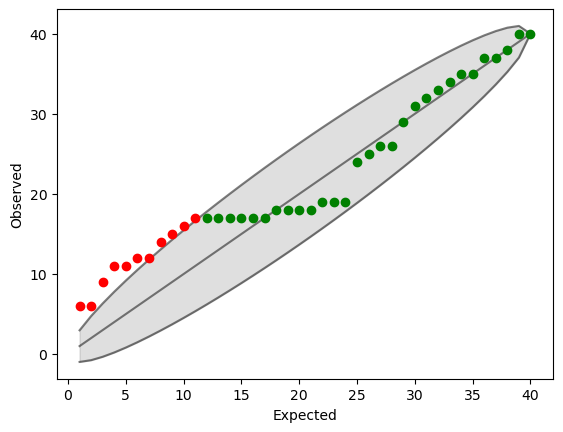

In [94]:
_ = dds.extremes_plot(X_train_dds, upper_frac=1.0)

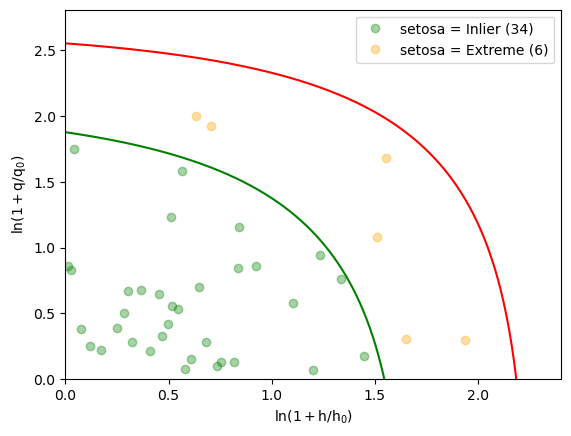

In [95]:
# There are no outliers in this training set, so we don't have to worry about removing any points (at least for this
# n_components).
_ = dds.visualize(X_train_dds, y_train_dds)

In [96]:
# Extremes and Outliers can be found using the check_outliers() function.
extremes_mask, outliers_mask = dds.check_outliers(X_train_dds)

print(
    "There are {} extremes and {} outliers in the training data.".format(
        np.sum(extremes_mask),
        np.sum(outliers_mask)
    )
)

There are 6 extremes and 0 outliers in the training data.


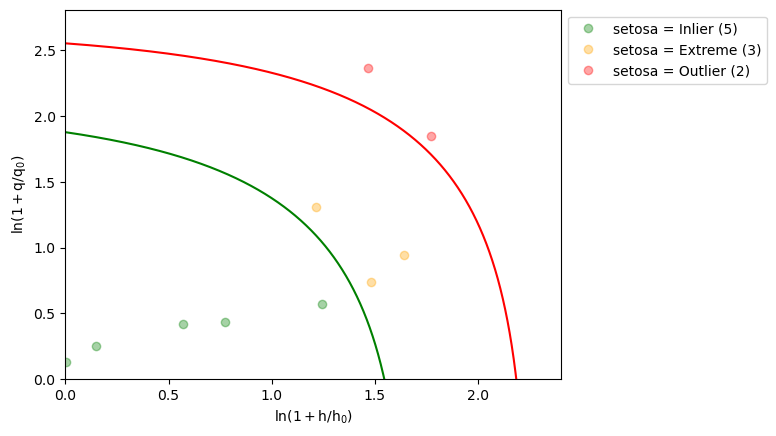

In [97]:
# However, the test set, which is also composed of known setosa examples, has several extremes and outliers which 
# would be rejected as not "authentic" in this model.
_ = dds.visualize(X_test_dds, y_test_dds)

In [98]:
# We can see what samples are classified as 'Pure' using the predict() function.
pure_sample_mask = dds.predict(X_test_dds)

# These are accepted as authentic.
X_test_dds[pure_sample_mask]

array([[4.4, 3. , 1.3, 0.2],
       [5. , 3.4, 1.5, 0.2],
       [5. , 3.3, 1.4, 0.2],
       [5.4, 3.7, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2]])

In [99]:
# These are rejected
X_test_dds[~pure_sample_mask]

array([[4.4, 3.2, 1.3, 0.2],
       [4.6, 3.6, 1. , 0.2],
       [5.4, 3.4, 1.7, 0.2],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 3.8, 1.7, 0.3]])

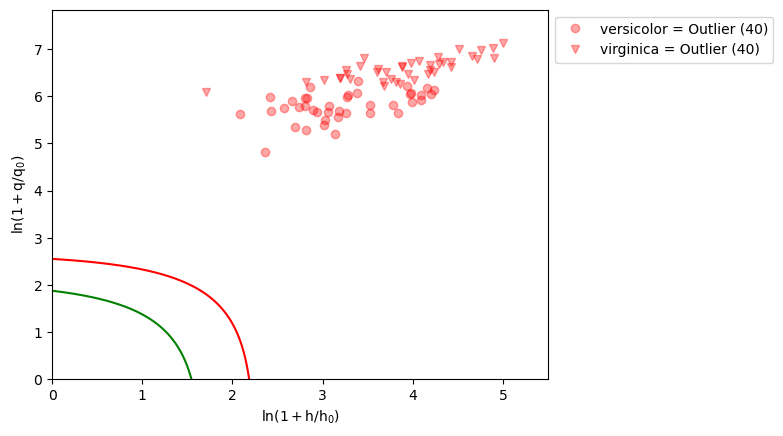

In [100]:
# We can also look at well the model rejects the other classes as authentic setosa
X_other = X_train[y_train != chosen_class]
y_other = y_train[y_train != chosen_class]

# At least this model seems very specific since these other classes are easily rejected!
_ = dds.visualize(X_other, y_other)

In [101]:
# Accuracy is computed by simply counting the number of binary (authentic/not) assignments.
train_acc = dds.accuracy(
    X = X_train_dds,
    y = [True] * len(X_train_dds) # We do not use y_train here!
)

test_acc = dds.accuracy(
    X = X_test_dds,
    y = [True] * len(X_test_dds)
)

print(
    "Training set accuracy = {}%; test set accuracy = {}%.".format(
        '%.1f'%(100.0*train_acc),
        '%.1f'%(100.0*test_acc)
    )
)

Training set accuracy = 85.0%; test set accuracy = 50.0%.


In [102]:
# Accuracy is also reported as the score
dds.score(X_train_dds, [True] * len(X_train_dds))

0.85

In [103]:
# Accuracy is also reported as the score
dds.score(X_train[y_train == 'virginica'], [False] * np.sum(y_train == 'virginica'))

1.0

Building an Authenticator
---

<div class="alert alert-block alert-info"> 
In training loops and other applications it is convenient to not have to separate classes for training.  This is one thing that SIMCA_Authenticator conveniently does for you, which is illustrated below.  Here, we simply specify the class we care about and all others are automatically ignored like we did manually above.  
</div>

<div class="alert alert-block alert-warning"> 
Another factor we need to consider is that there are 2 ways to train an authentication model [1].  A "rigorous" approach would be to train a model considering only the true examples of a known class.  We could select a desired `alpha` value and adjust `n_components` to try to achieve this, since it is the desired type I error rate.  This is essentially like setting the accuracy for true positives (TSNS), while ignoring the behavior with respect to alternative classes.  
<br><br>
Alternatively, we could use examples of alternatives and adjust our hyperparameters to optimize an overall metric like total efficiency (TEFF) which considers how often we get true positives correct (TSNS) and how often we correctly reject the true negatives (TSPS). This is a "compliant" approach. These sorts of models use more information and might seem more performant, but this data is always biased by the set of known alternatives we use.  Since there are an infinite number of inauthentic things, this introduces some bias which can be difficult to quantify.

<a href="https://doi.org/10.1016/j.chemolab.2016.10.002">[1] "Rigorous and compliant approaches to one-class classification," Rodionova, O., Oliveri, P., and Pomerantsev, A. Chem. and Intell. Lab. Sys. (2016) 89-96.</a>
    
</div>

In [ ]:
from pychemauth.classifier.simca import SIMCA_Authenticator

In [ ]:
compliant = SIMCA_Authenticator(
    n_components=7, 
    alpha=0.05, 
    scale_x=False, 
    style='dd-simca', 
    target_class='setosa', # Tell the classifier
    use='compliant'
)

In [ ]:
# Combine the training (all Pure) and alternate data to create a new training set that has multiple (in this
# case 2) classes.  We specified the target_class='Pure' above, which tells the classifier that we are trying
# to model that class.  ONLY that data is used to fit the model; all other classes it is provided will be
# ignored.
x_train = np.vstack((raw_x, raw_x_a))
y_train = np.hstack((raw_y, raw_y_a))
_ = sc.fit(x_train, y_train)

In [ ]:
# By default, TEFF is used to score the classifer, you can change this when then classifier is instantiated.
sc.score(x_train, y_train) # TEFF = sqrt(TSNS * TSPS)

In [ ]:
sc.metrics(x_train, y_train)

In [ ]:
# Look at all the data.
_ = sc.model.visualize(x_train, y_train)

In [ ]:
# Look at just the data used to train the underlying SIMCA_Model.
_ = sc.model.visualize(raw_x, raw_y)

In [ ]:
# Look at the data used to test how well the model performs by classifying alternative samples.
_ = sc.model.visualize(raw_x_a, raw_y_a)

Optimizing the Classifier
---

Here we took alpha as a meaningful choice of type I error rate, but it could also be adjusted.  Moreover, we arbitrarily selected the number of PCs to use in the SIMCA model.  We can use scikit-learn's pipelines to automatically optimize hyperparameters like this.

In [ ]:
# Here I've use an imblearn pipeline, but you can also use scikit-learn's pipeline if you don't want to 
# do any class balancing.

pipeline = imblearn.pipeline.Pipeline(steps=[
    # Insert other preprocessing steps here...
    # ("smote", ScaledSMOTEENN(random_state=1)), # For example, class balancing
    ("simca", SIMCA_Classifier(n_components=7, 
                               alpha=0.05, 
                               scale_x=False, 
                               style='dd-simca', 
                               target_class='Pure', 
                               use='compliant')
    )
])

# Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
param_grid = [{
    # 'smote__k_enn':[1, 2, 3],
    # 'smote__k_smote':[1, 3, 3],
    # 'smote__kind_sel_enn':['all', 'mode'],
    'simca__n_components':np.arange(1, 10),
    # 'simca__alpha':[0.07, 0.05, 0.03, 0.01],
    # 'simca__style':['dd-simca', 'simca'],
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
    error_score=0,
    refit=True
)

_ = gs.fit(x_train, y_train)

In [ ]:
# The best parameters found can be accessed like this:
gs.best_params_

In [ ]:
gs.best_score_ # The best score it received was...

In [ ]:
# You can see detailed CV results here
gs.cv_results_

In [ ]:
# For a 1D optimization you can easily visualize where the best value is
plt.errorbar(np.arange(1, 10), gs.cv_results_['mean_test_score'], yerr=gs.cv_results_['std_test_score'])
plt.xlabel('n_components')
plt.ylabel('Mean Test Score (TEFF)')

In [ ]:
# The refit=True (default) refits the model on the data in the end so you can use it directly.
gs.best_estimator_.predict(raw_x) # raw_x was just Pure

In [ ]:
gs.best_estimator_.predict(raw_x_a) # raw_x_a was just Alternates

In [ ]:
_ = gs.best_estimator_.named_steps['simca'].model.visualize(x_train, y_train)

In [ ]:
gs.best_estimator_.named_steps['simca'].score(x_train, y_train) # The score being used here is TEFF

In [ ]:
gs.best_estimator_.named_steps['simca'].metrics(x_train, y_train)['tsns']

In [ ]:
gs.best_estimator_.named_steps['simca'].metrics(x_train, y_train)['tsps']

In [ ]:
gs.best_estimator_.named_steps['simca'].metrics(x_train, y_train)['teff'] # sqrt(TSPS*TSNS)